acceptance rate =  0.444
tempo esecuzione PMCMC : 42.0163 sec
marginal Y pmcmc =  6.531926063250048e+73


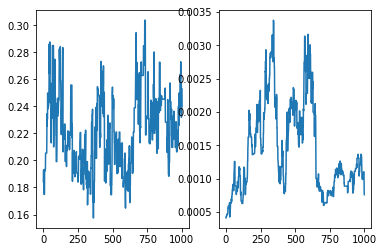

In [2]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
from particle_markov_chain_monte_carlo import Particle_marginal_Metropolis_Hastings

theta = [0.15, 0.0005, 0.04, 0.0035, 0.18, 0.0001]   # [0.27, 0.0005, 0.04, 0.0035, 0.18, 0.0001]

PMCMC = Particle_marginal_Metropolis_Hastings(number_of_iterations=1000)
start = time()
PMCMC.sample_PMCMC(1, theta)
print("tempo esecuzione PMCMC : %.4f sec"% (time()-start))

fig , (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(PMCMC.NI),PMCMC.phi_PMCMC[:,0])
ax2.plot(np.arange(PMCMC.NI),PMCMC.phi_PMCMC[:,1])
print("marginal Y pmcmc = ", np.max(PMCMC.marginal_pmcmc))

non ci sono le phii

 
alpha = 2.5275e-01  	  kappa = 9.8766e-04
marginal Y SMC sampled =  1.4600721435936272e+75

 
alpha = 2.3986e-01  	  kappa = 7.6038e-04
marginal Y PMPCMC sampled =  1.8184338517521604e+72

 
alpha = 2.5275e-01  	  kappa = 9.8766e-04
marginal Y PMCMC max =  6.531926063250048e+73


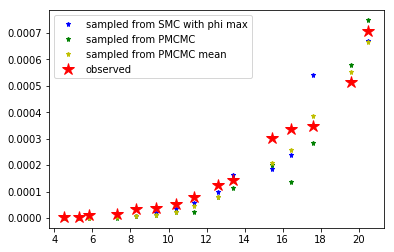

In [3]:
ind_max = np.argmax(PMCMC.marginal_pmcmc)
theta2 = [PMCMC.phi_PMCMC[ind_max,0], PMCMC.phi_PMCMC[ind_max,1] , 0.5, 35e-3, 0.1, 1e-5]
PMCMC.fit_SMC(1, theta2)  #np.mean(PMCMC.phi_PMCMC[0,800:])
plt.plot(PMCMC.timei, PMCMC.sampling_a_path().flatten(), "b*", markersize=5, label = "sampled from SMC with phi max")
plt.plot(PMCMC.timei, PMCMC.X_PMCMC[-1,:], "g*", markersize=5, label = "sampled from PMCMC")
plt.plot(PMCMC.timei, np.mean(PMCMC.X_PMCMC, axis=0), "y*", markersize=5, label = "sampled from PMCMC mean")

plt.plot(PMCMC.timei, PMCMC.yobsi, "r*", markersize=12, label = "observed")
plt.legend()

print("\n \nalpha = %.4e  \t  kappa = %.4e"%(PMCMC.phi_PMCMC[ind_max,0], PMCMC.phi_PMCMC[ind_max,1]))
print("marginal Y SMC sampled = ", PMCMC.marginal_y)

print("\n \nalpha = %.4e  \t  kappa = %.4e"%(PMCMC.phi_PMCMC[-1,0], PMCMC.phi_PMCMC[-1,1]))
print("marginal Y PMPCMC sampled = ", PMCMC.marginal_pmcmc[-1])

print("\n \nalpha = %.4e  \t  kappa = %.4e"%(PMCMC.phi_PMCMC[ind_max,0], PMCMC.phi_PMCMC[ind_max,1]))
print("marginal Y PMCMC max = ", PMCMC.marginal_pmcmc[np.argmax(PMCMC.marginal_pmcmc)])



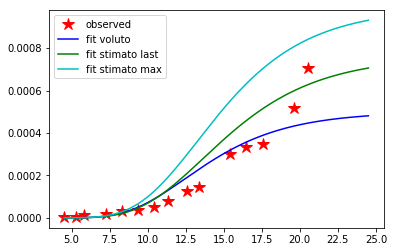

In [11]:
def drift( X,  par ):
    alpha = par[0]; kappa = par[1]
    dXdt = alpha* np.log(kappa/X)*X
    return dXdt 


def eulerStep_vec( par):
    time_vec = np.linspace(0.0, 20, 20000)
    delta_time = time_vec[1] - time_vec[0]
    xmean = np.zeros(20000)
    xmean[0] = 1e-7
    for i in range(1,20000):        
        xmean[i]= xmean[i-1] + drift(xmean[i-1], par)* delta_time
    return (time_vec, xmean)

t_v_voluti, x_m_voluti = eulerStep_vec( par=[0.27, 5e-4 ])
t_v_stimati, x_m_stimati = eulerStep_vec( par=[PMCMC.phi_PMCMC[-1,0], PMCMC.phi_PMCMC[-1,1]])
t_v_stimati2, x_m_stimati2 = eulerStep_vec( par=[PMCMC.phi_PMCMC[ind_max,0], PMCMC.phi_PMCMC[ind_max,1]])

plt.plot(PMCMC.timei, PMCMC.yobsi, "r*", markersize=12, label = "observed")
plt.plot(PMCMC.timei[0]+t_v_voluti, x_m_voluti, "b-", label = "fit voluto")
plt.plot(PMCMC.timei[0]+t_v_stimati, x_m_stimati, "g-", label = "fit stimato last")
plt.plot(PMCMC.timei[0]+t_v_stimati2, x_m_stimati2, "c-", label = "fit stimato max")
plt.legend()

da questo ultimo plot si vede bene che massimizzare soltanto il marginal non porta frutti

In [24]:
from particle_markov_chain_monte_carlo import Sequential_Monte_Carlo
from scipy.stats import multivariate_normal, norm
class Particle_marginal_Metropolis_Hastings(Sequential_Monte_Carlo):
    def __init__(self, number_of_iterations=100):
        self.NI = number_of_iterations
        #self.SMC = Sequential_Monte_Carlo()
        Sequential_Monte_Carlo.__init__(self)
      
    
    def sample_PMCMC(self, soggetto, theta):
        self.select_subj(soggetto)
        self.X_PMCMC = np.zeros((self.NI, len(self.yobsi)))
        self.phi_PMCMC = np.zeros((self.NI, 2))
        self.marginal_pmcmc = np.zeros(self.NI)
        
        self.theta = theta
        
        #inizializza la prior... faccio questo per velocizzare
        O = np.diag([self.theta[2]**2,self.theta[3]**2])
        self.prior = multivariate_normal(self.theta[:2], O)
        
        accept = 0
        
        phi = self.proposalPhi_sample(np.array(theta[:2]))  # vedere se cambiare...  
        self.phi_PMCMC[0,:] = phi
        
        self.fit_SMC(  soggetto , theta, phi  )
        X = self.sampling_a_path()
        self.X_PMCMC[0, :] = X
        self.marginal_pmcmc[0] = self.marginal_y
        
        
        for i in range(1, self.NI):
            phi_star = self.proposalPhi_sample(phi)
            
            self.fit_SMC( soggetto, theta , phi_star)
            X_star = self.sampling_a_path();
            marginal_star = self.marginal_y
            
            num = (marginal_star* self.prior_phi(phi_star) * self.proposal_evaluation(phi_star, phi))
            den = (self.marginal_pmcmc[i-1]* self.prior_phi(phi) * self.proposal_evaluation(phi, phi_star) )
            prob_acceptance = np.min([1. , num/den ])
            
            if prob_acceptance > np.random.uniform():
                accept += 1
                self.X_PMCMC[i,:] = X_star
                self.phi_PMCMC[i,:] = phi_star
                self.marginal_pmcmc[i] = marginal_star
                X = X_star
                phi = phi_star
            else:
                self.X_PMCMC[i,:] = X
                self.phi_PMCMC[i,:] = phi
                self.marginal_pmcmc[i] = self.marginal_pmcmc[i-1]

            
        print("acceptance rate = ", accept/self.NI)
        return [phi, X]
    
    
    def proposalPhi_sample(self, prec_phi):
        deviance = 0.1*prec_phi
        deviance[deviance < 1e-12] = 1e-12
        sampled = np.array([prec_phi[i] + deviance[i]*np.random.normal() for i in range(2)])
        sampled[sampled < 1e-12] = 1e-12
        return sampled
    
    def prior_phi(self, phi ):
        return self.prior.pdf(phi)
    
    def proposal_evaluation(self, phi_new, phi_mean):
        var = np.array((0.1 * phi_mean)**2)
        var[var < 1e-12] = 1e-12
        variance = np.diag(var)
        #print(phi_new, phi_mean, multivariate_normal( phi_mean, variance).pdf(phi_new))
        return multivariate_normal( phi_mean, variance).pdf(phi_new)
    
#    def get_better_fit(self):
 #      self.ind_max = np.argmax(self.marginal_pmcmc)
        
  #      return (self.phi_PMCMC[self.ind_max, :], self.X_PMCMC[self.ind_max, :])

acceptance rate =  0.519
tempo esecuzione PMCMC : 40.3771 sec
marginal Y pmcmc =  6.565780952597354e+73


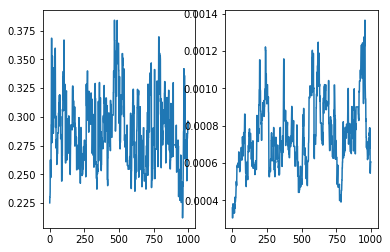

In [25]:
PMCMC = Particle_marginal_Metropolis_Hastings(number_of_iterations=1000)
start = time()
PMCMC.sample_PMCMC(1, theta)
print("tempo esecuzione PMCMC : %.4f sec"% (time()-start))

fig , (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(PMCMC.NI),PMCMC.phi_PMCMC[:,0])
ax2.plot(np.arange(PMCMC.NI),PMCMC.phi_PMCMC[:,1])
print("marginal Y pmcmc = ", np.max(PMCMC.marginal_pmcmc))

In [26]:
theta

[0.27, 0.0005, 0.04, 0.0035, 0.18, 0.0001]

In [20]:
np.argmax(PMCMC.marginal_pmcmc), PMCMC.marginal_pmcmc[ np.argmax(PMCMC.marginal_pmcmc)]
                                                      

(978, 5.87246344299652e+73)

In [ ]:
np.mean(PMCMC.phi_PMCMC[:,0]), np.mean(PMCMC.phi_PMCMC[:,1])

non ci sono le phii
marginal Y SMC sampled =  3.338452394655049e+55
marginal Y PMPCMC sampled =  1.9452597083328106e+73
marginal Y PMCMC max =  5.87246344299652e+73


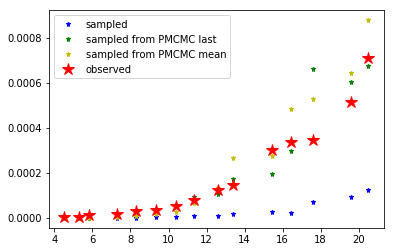

In [23]:
PMCMC.fit_SMC(1, [np.mean(PMCMC.phi_PMCMC[0,:]), 5e-4 , 0.5, 35e-3, 0.1, 1e-4])  #np.mean(PMCMC.phi_PMCMC[0,800:])
plt.plot(PMCMC.timei, PMCMC.sampling_a_path().flatten(), "b*", markersize=5, label = "sampled")
plt.plot(PMCMC.timei, PMCMC.X_PMCMC[-1,:], "g*", markersize=5, label = "sampled from PMCMC last")
plt.plot(PMCMC.timei, PMCMC.X_PMCMC[np.argmax(PMCMC.marginal_pmcmc),:], "y*", markersize=5, label = "sampled from PMCMC mean")
plt.plot(PMCMC.timei, PMCMC.yobsi, "r*", markersize=12, label = "observed")
plt.legend()

print("marginal Y SMC sampled = ", PMCMC.marginal_y)
print("marginal Y PMPCMC sampled = ", PMCMC.marginal_pmcmc[-1])
print("marginal Y PMCMC max = ", PMCMC.marginal_pmcmc[np.argmax(PMCMC.marginal_pmcmc)])

In [23]:
PMCMC.X_PMCMC[-1,:]

array([1.00000000e-07, 3.52030186e-07, 8.90358452e-07, 1.59899048e-06,
       5.80737169e-06, 1.48826895e-05, 1.52740815e-05, 1.96038072e-05,
       1.19554268e-04, 8.57635434e-05, 1.84463704e-04, 1.74744128e-04,
       3.31668045e-04, 3.73575671e-04, 7.21285126e-04])

In [1]:
theta = [0.1598523555361324 , 0.0054268859793400086, 0.5, 35e-3, 0.2, 1e-3]
phi, X =PMCMC.sample_PMCMC(1, theta)
SMC = Sequential_Monte_Carlo()
theta = [0.1598523555361324 , 0.0054268859793400086, 0.5, 35e-3, 0.2, 1e-5]
SMC.fit_SMC(1, theta)

plt.plot(PMCMC.timei, X.flatten(), "b*", markersize=5, label = "sampled")

plt.plot(PMCMC.timei, PMCMC.yobsi, "r*", markersize=12, label = "observed")
plt.legend()

print("marginal Y = ", PMCMC.marginal_y)

NameError: name 'PMCMC' is not defined

In [26]:
start = time()
PMCMC.fit_SMC(1, theta)

print("tempo esecuzione : ", time()-start)

tempo esecuzione :  0.04867291450500488


In [59]:
%%timeit
np.random.uniform()

733 ns ± 0.526 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [4]:

plt.plot(timei, yobsi, "r*",markersize=8, label= "observed values")
plt.plot(timei, SMC.sampling_a_path().flatten(), "b*",markersize=8, label= "observed values")

NameError: name 'timei' is not defined